<a href="https://colab.research.google.com/github/professor4044/NLP-Project/blob/main/NLPProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Minimun Edit Distance

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def min_edit_distance(str1, str2):
    m, n = len(str1), len(str2)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],
                    dp[i][j - 1],
                    dp[i - 1][j - 1]
                )
    return dp, dp[m][n]

def similarity_score(str1, str2):
    dp, distance = min_edit_distance(str1, str2)
    max_len = max(len(str1), len(str2))
    similarity = 1 - (distance / max_len) if max_len != 0 else 1.0
    return similarity, distance, dp

string1 = input("1st text: ").strip().lower()
string2 = input("2nd text: ").strip().lower()

similarity, distance, dp = similarity_score(string1, string2)

print("=== String Similarity Calculator ===")
print(f"String 1: {string1}")
print(f"String 2: {string2}")
print(f"\nMinimum Edit Distance: {distance}")
print(f"Similarity Score: {similarity:.2f}")

1st text: JABED
2nd text: JAMIR
=== String Similarity Calculator ===
String 1: jabed
String 2: jamir

Minimum Edit Distance: 3
Similarity Score: 0.40


TASK : 1 : Load Python Libraries

In [25]:
import os, re, json, time, random, string, urllib.request
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

random.seed(42)
np.random.seed(42)
import sklearn, matplotlib


TASK : 2 : Load NLTK package

In [26]:
packages = [
    "punkt", "stopwords", "wordnet", "omw-1.4",
    "averaged_perceptron_tagger", "averaged_perceptron_tagger_eng",
    "punkt_tab"
]
for p in packages:
    try:
        nltk.download(p, quiet=True)
    except Exception as e:
        print(f"NLTK download failed for {p}: {e}")

STOP_WORDS = set(stopwords.words("english"))
stemmer = PorterStemmer()
wnl = WordNetLemmatizer()
print("NLTK done")

NLTK done


TASK : 3 :Load dataset

In [27]:
from datasets import load_dataset
import pandas as pd
from collections import Counter

dataset = load_dataset("csv", data_files="fake.csv", split="train[:10000]")

df = pd.DataFrame(dataset)

print(df.head(3))

print("Label distribution:", Counter(df["type"].tolist()))

print("Total rows:", len(df))


                                       uuid  ord_in_thread  \
0  6a175f46bcd24d39b3e962ad0f29936721db70db              0   
1  2bdc29d12605ef9cf3f09f9875040a7113be5d5b              0   
2  c70e149fdd53de5e61c29281100b9de0ed268bc3              0   

                 author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   

                                                text language  \
0  Print They should pay all the back all the mon...  english   
1  Why Did Attorney General Loretta Lynch Plead T...  english   
2  Red State : \nFox News Sunday reported this mo...  english   

                         crawled

TASK:4:Tokenization

In [28]:
from nltk.tokenize import word_tokenize

def tokenize(column_data):
    return [word_tokenize(str(t)) for t in column_data]

tokenized_text = tokenize(df['text'])

print(tokenized_text[0][:50])

['Print', 'They', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', '.', 'The', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', '.', 'Why', 'did', 'it', 'take', 'two', 'years', 'to', 'bust', 'them', '?', 'Here', 'we', 'go', 'again', '…another', 'group', 'stealing', 'from', 'the', 'government', 'and']


TASK:5:Case folding

In [29]:

def to_lower(tokens_list):
    return [[t.lower() for t in toks] for toks in tokens_list]

lowered_corpus = to_lower(tokenized_text)

print(lowered_corpus[0][:50])

['print', 'they', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', '.', 'the', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', '.', 'why', 'did', 'it', 'take', 'two', 'years', 'to', 'bust', 'them', '?', 'here', 'we', 'go', 'again', '…another', 'group', 'stealing', 'from', 'the', 'government', 'and']


TASK:6:Punctuation Removal

In [30]:
import re
def clean_tokens(doc_tokens):
    clean_doc = []
    for token in doc_tokens:
        new_token = re.sub(r'[^a-zA-Z0-9]', '', token)

        if new_token != '':
            clean_doc.append(new_token)
    return clean_doc

final_cleaned_text = [clean_tokens(tokens) for tokens in lowered_corpus]

print(final_cleaned_text[0][:30])

['print', 'they', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', 'the', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', 'why', 'did', 'it']


TASK:7:Stop word removal

In [31]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens_list):
    return [word for word in tokens_list if word not in stop_words]

text_without_stopwords = [remove_stopwords(tokens) for tokens in final_cleaned_text]

print(text_without_stopwords[0][:30])

['print', 'pay', 'back', 'money', 'plus', 'interest', 'entire', 'family', 'everyone', 'came', 'need', 'deported', 'asap', 'take', 'two', 'years', 'bust', 'go', 'another', 'group', 'stealing', 'government', 'taxpayers', 'group', 'somalis', 'stole', 'four', 'million', 'government', 'benefits']


TASK:8:Lemmatization

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

lemmatized_output = [lemmatize_text(tokens) for tokens in text_without_stopwords]

print(lemmatized_output[0][:30])

['print', 'pay', 'back', 'money', 'plus', 'interest', 'entire', 'family', 'everyone', 'came', 'need', 'deported', 'asap', 'take', 'two', 'year', 'bust', 'go', 'another', 'group', 'stealing', 'government', 'taxpayer', 'group', 'somali', 'stole', 'four', 'million', 'government', 'benefit']


TASK:9:Synonym Substitution

In [33]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

def synonym_substitution(tokens_list):
    new_sentence = []
    for word in tokens_list:
        synonyms = wordnet.synsets(word)

        if synonyms:
            new_word = synonyms[0].lemmas()[0].name()

            if new_word != word and "_" not in new_word:
                new_sentence.append(new_word)
            else:
                new_sentence.append(word)
        else:
            new_sentence.append(word)

    return new_sentence

synonym_replaced_data = [synonym_substitution(tokens) for tokens in lemmatized_output]

print(synonym_replaced_data[0][:30])

['print', 'wage', 'back', 'money', 'asset', 'interest', 'stallion', 'family', 'everyone', 'come', 'need', 'behave', 'ASAP', 'return', 'two', 'year', 'flop', 'go', 'another', 'group', 'larceny', 'government', 'taxpayer', 'group', 'Somalian', 'stole', 'four', 'million', 'government', 'benefit']


TASK:10:Split (Train , Test/Validation)

In [34]:
from sklearn.model_selection import train_test_split

X_text = [" ".join(tokens) for tokens in synonym_replaced_data]

X = X_text
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Total Data:", len(X))
print("Training Data Size (80%):", len(X_train))
print("Testing Data Size (20%):", len(X_test))

Total Data: 10000
Training Data Size (80%): 8000
Testing Data Size (20%): 2000


TASK:11:Using TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Training Data Shape:", X_train_tfidf.shape)
print("Testing Data Shape:", X_test_tfidf.shape)

Training Data Shape: (8000, 118099)
Testing Data Shape: (2000, 118099)


TASK:12:Applying Naïve Bayes Algorithm

In [36]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)

print("Naive Bayes algorithm has been applied successfully.")

Naive Bayes algorithm has been applied successfully.


TASK:13:Confusion matrix & Curve (ROC, AUC)

Accuracy:  0.7945
Precision: 0.8000
Recall:    0.7778
F1-score:  0.7887

Classification report:

              precision    recall  f1-score   support

    Real (0)       0.79      0.81      0.80        74
    Fake (1)       0.80      0.78      0.79        72

    accuracy                           0.79       146
   macro avg       0.79      0.79      0.79       146
weighted avg       0.79      0.79      0.79       146



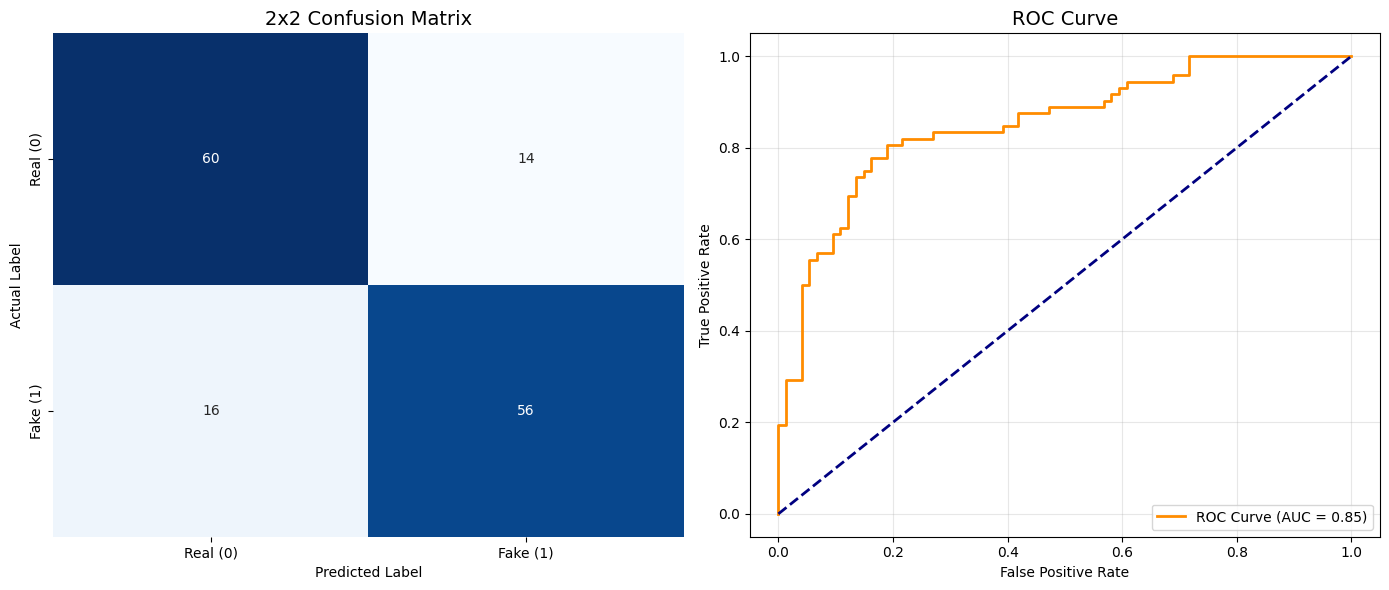

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, roc_auc_score)
try:
    if 'df' not in locals():
        df = pd.read_csv('fake.csv')
        print("✅ Dataset loaded successfully.")
except:
    print("⚠️ Error: 'fake.csv' file not found! Please upload the dataset.")

text_col = 'text'

if 'synonym_replaced_data' in locals():
    if len(df) == len(synonym_replaced_data):
        df['clean_text'] = [" ".join(tokens) for tokens in synonym_replaced_data]
        text_col = 'clean_text'
    else:
        print(f"⚠️ Warning: Size Mismatch! Dataset has {len(df)} rows but processed list has {len(synonym_replaced_data)}.")
        print("➡️ Switching to original 'text' column to prevent errors.")
else:
    print("ℹ️ Processed data not found. Using original 'text' column.")

df[text_col] = df[text_col].fillna('')
df[text_col] = df[text_col].astype(str)

label_mapping = {
    'fake': 1, 'conspiracy': 1, 'bs': 1, 'junksci': 1, 'satire': 1, 'hate': 1,
    'bias': 0, 'state': 0
}

if 'type' in df.columns:
    if df['type'].dtype == object:
        df['binary_type'] = df['type'].map(label_mapping)
    else:
        df['binary_type'] = df['type']

df = df.dropna(subset=['binary_type'])
df['binary_type'] = df['binary_type'].astype(int)

df_0 = df[df['binary_type'] == 0]
df_1 = df[df['binary_type'] == 1]
min_len = min(len(df_0), len(df_1))

df_balanced = pd.concat([
    df_0.sample(min_len, random_state=42),
    df_1.sample(min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[text_col]
y = df_balanced['binary_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred = nb_model.predict(X_test_vec)
y_proba = nb_model.predict_proba(X_test_vec)[:, 1]

print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.title('2x2 Confusion Matrix', fontsize=14)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.subplot(1, 2, 2)
auc_score = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.legend(loc="lower right")
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()